In [ ]:
# default_exp geometry.abstract_geometry

# Create abstract geometry

> API details.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
from shapely.geometry import Point, box, Polygon, MultiPoint, MultiPolygon, LineString, MultiLineString
from geocube.api.core import make_geocube
import geopandas as gpd
import numpy as np
import pickle

In [ ]:
#hide
box_size = (100, 100)
circle_radius = 10
n_circles = 10

In [ ]:
#export
class AbstractGeometry:
    def __init__(self, n_circles, circle_radius, box_size, seed=42):
        self.n_circles = n_circles
        self.box_size = box_size
        self.circle_radius = circle_radius
        self.seed = seed

    def get_geom_info(self):
        circles_centers = self._generate_random_circles()
        box_corner_coords = self._get_box_corner_coords()

        return circles_centers, self.circle_radius, box_corner_coords
    
    def _get_box_corner_coords(self):
        return [[0, 0], 
                [self.box_size[0], 0], 
                [self.box_size[0], self.box_size[1]], 
                [0, self.box_size[1]]]

    def _generate_random_circles(self):
        np.random.seed(self.seed)

        circle_centers = []
        counter = 1
        attempts = 0
        circles = MultiPolygon([])
        circles_centers = []

        while counter<self.n_circles:
            attempts += 1
            if attempts > 100 * self.n_circles:
                raise Exception(f'{attempts} attempts, reduce circle radius, increase box size, or decrease number of circles')
            cx, cy = self._generate_random_center()
            if self._is_inside_box(cx, cy):
                circle = Point(cx, cy).buffer(self.circle_radius)
                circles_tmp = MultiPolygon([g for g in circles.geoms] + [circle])
                if circles_tmp.is_valid:
                    circles = circles_tmp
                    circles_centers.append((cx, cy))
                    counter += 1

        return circles_centers
        
    def _is_inside_box(self, center_x, center_y):
        is_in_left = (center_x-self.circle_radius > 0)
        is_in_right = (center_x+self.circle_radius < self.box_size[0])
        is_in_top = (center_y+self.circle_radius < self.box_size[1])
        is_in_bot = (center_y-self.circle_radius > 0)

        if is_in_left and is_in_right and is_in_top and is_in_bot:
            return True 
        else:
            return False
    
    def _generate_random_center(self):
        x_frac, y_frac = np.random.random((2))
        center_x = self.box_size[0] * x_frac
        center_y = self.box_size[1] * y_frac
        return (center_x, center_y)

    def save_at(self, path):
        with open(path, 'wb') as handle:
            pickle.dump(self, handle)

In [ ]:
abstract_geometry = AbstractGeometry(10, circle_radius, box_size, 42)
circle_centers, circle_radius, box_corner_coords = abstract_geometry.get_geom_info()

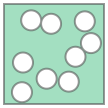

In [ ]:
boxx = box(0, 0, box_size[0], box_size[1])
box_wo_circles = boxx.difference(circles)
box_wo_circles

In [ ]:
print(type(circles.boundary))

<class 'shapely.geometry.multilinestring.MultiLineString'>


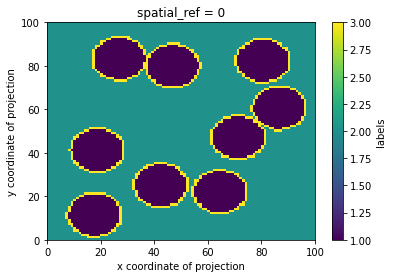

In [ ]:
g = gpd.GeoDataFrame(
    {"labels": [1, 2, 3]},
    geometry=[circles, box_wo_circles, circles.boundary],
    crs={"init": "epsg:4326"}
)
 
boundaries = make_geocube(vector_data=g, resolution=(1, 1), fill=0)
boundaries.labels.plot()